# UWB Signal Range Prediction with GPU Support

This notebook implements range prediction for UWB signals using PyTorch with GPU acceleration.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
def import_from_files(dataset_path='dataset/'):
    """Read .csv files and store data into an array."""
    # Look for dataset in parent directory since notebook is in code/
    dataset_path = os.path.join('..', dataset_path)
    abs_path = os.path.abspath(dataset_path)
    if not os.path.exists(abs_path):
        raise FileNotFoundError(f"Dataset directory not found at: {abs_path}")
        
    output_arr = []
    first = 1
    files_processed = 0
    
    for dirpath, dirnames, filenames in os.walk(abs_path):
        csv_files = [f for f in filenames if f.endswith('.csv')]
        
        for file in csv_files:
            filename = os.path.join(dirpath, file)
            print(f"Processing file: {filename}")
            
            try:
                df = pd.read_csv(filename, sep=',', header=0)
                input_data = df.to_numpy()
                
                if first > 0:
                    first = 0
                    output_arr = input_data
                else:
                    output_arr = np.vstack((output_arr, input_data))
                files_processed += 1
                print(f"Successfully loaded data from {filename}")
                
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                continue
    
    if files_processed == 0:
        raise ValueError("No data was loaded from any CSV files")
        
    print(f"Successfully processed {files_processed} files")
    print(f"Dataset shape: {output_arr.shape}")
    return output_arr

In [3]:
class UWBDataset(Dataset):
    """PyTorch Dataset for UWB data."""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class RangePredictor(nn.Module):
    """Neural network for range prediction."""
    def __init__(self, input_size):
        super(RangePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.layers(x).squeeze()

In [4]:
def prepare_data(dataset_path='dataset/'):
    """Load and prepare data for training."""
    try:
        print("Loading dataset...")
        data = import_from_files(dataset_path)
        
        if data is None or len(data) == 0:
            raise ValueError("Empty dataset received")
            
        print(f"Data shape: {data.shape}")
        
        # Prepare features and target
        X = data[:, 1:15]  # Features (excluding measured range and CIR values)
        y = data[:, 0]     # Target (measured range)
        
        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create datasets
        train_dataset = UWBDataset(X_train_scaled, y_train)
        test_dataset = UWBDataset(X_test_scaled, y_test)
        
        return train_dataset, test_dataset, scaler
        
    except Exception as e:
        print(f"Error preparing data: {str(e)}")
        raise

In [5]:
def train_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=50):
    """Train the neural network model."""
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_test_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

In [6]:
def evaluate_model(model, test_loader):
    """Evaluate the model and create visualization plots."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    y_pred = np.array(all_preds)
    y_test = np.array(all_targets)
    
    # Calculate metrics
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
    
    print("\nModel Performance:")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', 
             lw=2)
    plt.xlabel('Actual Range')
    plt.ylabel('Predicted Range')
    plt.title('Actual vs Predicted Range')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.show()
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Range')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.savefig('residuals.png')
    plt.show()
    
    return rmse, r2

Loading dataset...
Processing file: c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part1.csv
Successfully loaded data from c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part1.csv
Processing file: c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part2.csv
Successfully loaded data from c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part2.csv
Processing file: c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part3.csv
Successfully loaded data from c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part3.csv
Processing file: c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part4.csv
Successfully loaded data from c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part4.csv
Processing file: c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part5.csv
Successfully loaded data from c:\Code\Uni\DA-LOS-WirelessSignalPrediction\dataset\uwb_dataset_part5.csv
Proces

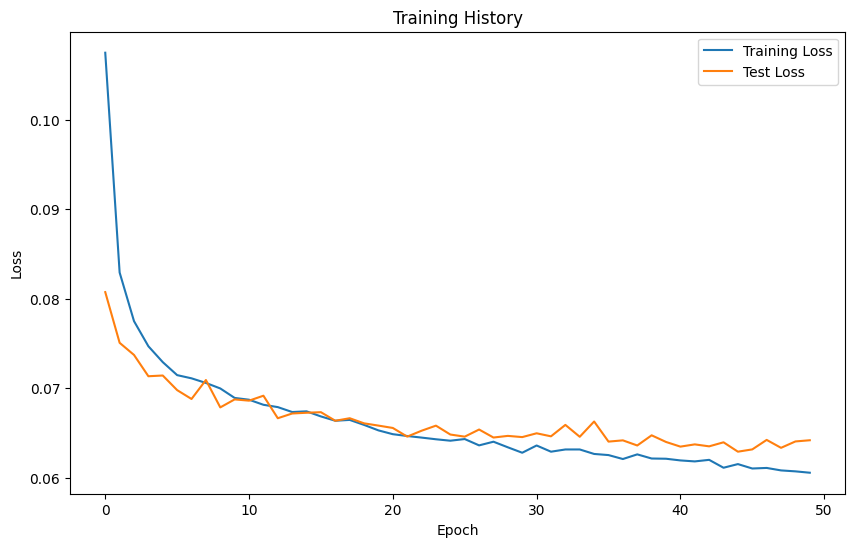


Model Performance:
Root Mean Square Error: 0.2524
R² Score: 0.7452


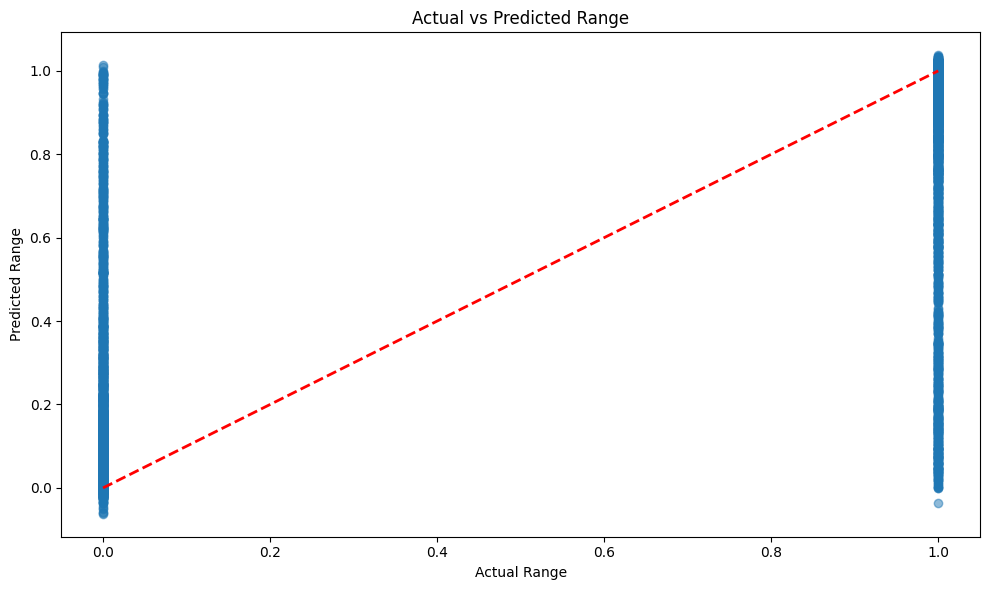

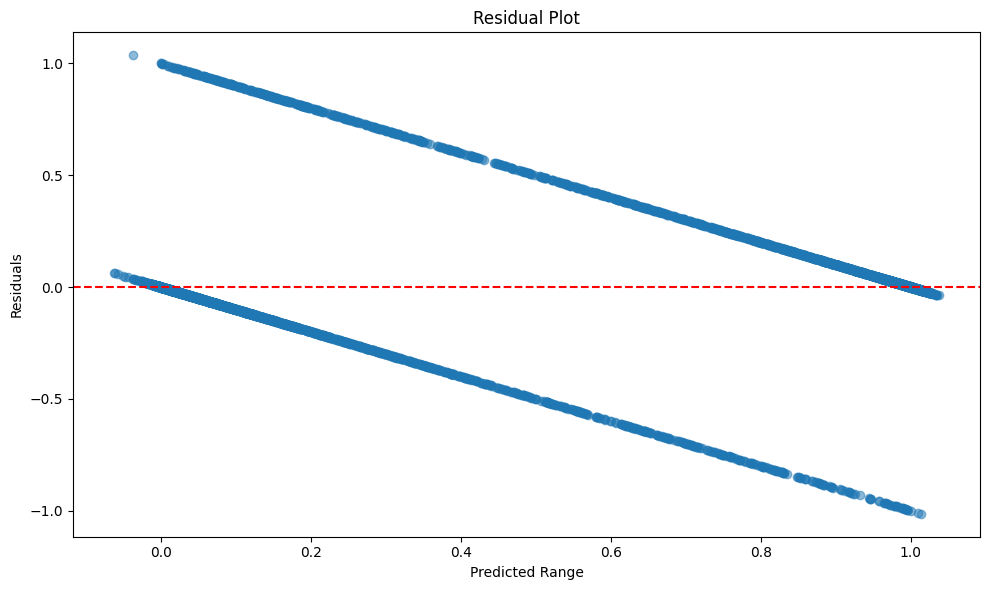

In [7]:
# Prepare the data
train_dataset, test_dataset, scaler = prepare_data()

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model
model = RangePredictor(input_size=14).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, test_losses = train_model(train_loader, test_loader, model, criterion, optimizer)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

# Evaluate the model
rmse, r2 = evaluate_model(model, test_loader)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler
}, 'uwb_model.pth')